In [1]:
import numpy as np 
import pandas as pd 
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D,Input,UpSampling2D, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2DTranspose, Layer, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
import keras.backend as K
import tensorflow as tf
#from tensorflow.keras import metrics
from keras.models import Sequential
from sklearn.metrics import f1_score, classification_report
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import random
# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")

2022-08-22 16:16:10.835820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 16:16:10.835842: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [3]:
train_path = "../../data/chest_xray/chest_xray/train"
test_path = "../../data/chest_xray/chest_xray/test"
val_path = "../../data/chest_xray/chest_xray/val"

def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [4]:
dsize =(64, 64)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [5]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [6]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

100%|██████████| 8/8 [00:00<00:00, 411.54it/s]


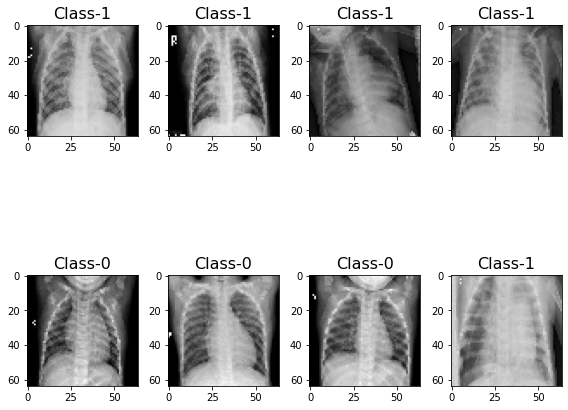

In [15]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

In [16]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [17]:
normalize = True

X_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", X_train.shape)

X_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", X_val.shape)

X_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", X_test.shape)

100%|██████████| 5216/5216 [00:00<00:00, 18562.11it/s]


Shape of X_train: (5216, 64, 64, 3)


100%|██████████| 16/16 [00:00<00:00, 15262.42it/s]


Shape of X_val: (16, 64, 64, 3)


100%|██████████| 624/624 [00:00<00:00, 22078.08it/s]

Shape of X_test: (624, 64, 64, 3)


In [26]:
batch_size = 64
epochs = 15
inChannel = 3
x, y = 64, 64
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

In [20]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [21]:
def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [23]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.RMSprop())

In [24]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0   

In [27]:
autoencoder_train = autoencoder.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))

Epoch 1/15
82/82 [==============================] - 75s 917ms/step - loss: 0.2111 - val_loss: 0.3509
Epoch 2/15
82/82 [==============================] - 74s 903ms/step - loss: 0.1951 - val_loss: 0.3380
Epoch 3/15
82/82 [==============================] - 74s 897ms/step - loss: 0.1923 - val_loss: 0.3525
Epoch 4/15
82/82 [==============================] - 74s 903ms/step - loss: 0.1917 - val_loss: 0.2944
Epoch 5/15
82/82 [==============================] - 73s 895ms/step - loss: 0.1914 - val_loss: 0.3357
Epoch 6/15
82/82 [==============================] - 73s 891ms/step - loss: 0.1914 - val_loss: 0.3020
Epoch 7/15
82/82 [==============================] - 74s 899ms/step - loss: 0.1914 - val_loss: 0.2986
Epoch 8/15
82/82 [==============================] - 73s 892ms/step - loss: 0.1913 - val_loss: 0.3039
Epoch 9/15
82/82 [==============================] - 74s 900ms/step - loss: 0.1912 - val_loss: 0.3182
Epoch 10/15
82/82 [==============================] - 74s 902ms/step - loss: 0.1914 - val_lo

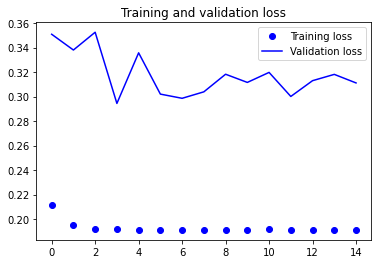

In [29]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(15)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
autoencoder.save_weights('/home/iotg/work/SWA/SWA/models/autoencoder_classifier.h5')

In [31]:
from keras.utils import to_categorical
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0.]


In [32]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(X_train,train_Y_one_hot,test_size=0.2,random_state=13)

In [33]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((4172, 64, 64, 3), (1044, 64, 64, 3), (4172, 2), (1044, 2))

In [34]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [35]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [36]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [37]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [38]:
autoencoder.get_weights()[0][1]

array([[[-1.43925443e-01, -9.86332744e-02, -1.38123825e-01,
          1.20049231e-01,  1.03434436e-01, -1.25749156e-01,
          1.13765180e-01,  7.20411688e-02, -1.58959150e-01,
         -9.76310745e-02,  7.78770819e-02,  1.07131474e-01,
         -1.16223380e-01,  1.06625155e-01, -3.16193290e-02,
          1.00479081e-01, -1.28957838e-01,  5.92245013e-02,
         -1.01004295e-01, -7.86957517e-02, -7.69468769e-02,
         -1.52382299e-01,  5.29278070e-02, -6.14752732e-02,
         -1.11850956e-02,  5.09022251e-02,  8.38368014e-02,
         -7.22508356e-02, -1.40080780e-01, -7.59148002e-02,
         -7.99553767e-02, -5.95268905e-02],
        [-1.53094856e-02, -4.71880622e-02, -9.20720324e-02,
          1.05515011e-01, -8.92089009e-02, -1.03944242e-01,
          9.28595662e-02, -1.11178875e-01,  9.47570801e-02,
         -1.14054263e-01, -1.38980612e-01,  9.96539667e-02,
         -7.33927041e-02,  1.70065276e-02,  3.09620611e-02,
         -4.48355414e-02, -1.03519142e-01,  1.05487511e-

In [39]:
full_model.get_weights()[0][1]

array([[[-1.43925443e-01, -9.86332744e-02, -1.38123825e-01,
          1.20049231e-01,  1.03434436e-01, -1.25749156e-01,
          1.13765180e-01,  7.20411688e-02, -1.58959150e-01,
         -9.76310745e-02,  7.78770819e-02,  1.07131474e-01,
         -1.16223380e-01,  1.06625155e-01, -3.16193290e-02,
          1.00479081e-01, -1.28957838e-01,  5.92245013e-02,
         -1.01004295e-01, -7.86957517e-02, -7.69468769e-02,
         -1.52382299e-01,  5.29278070e-02, -6.14752732e-02,
         -1.11850956e-02,  5.09022251e-02,  8.38368014e-02,
         -7.22508356e-02, -1.40080780e-01, -7.59148002e-02,
         -7.99553767e-02, -5.95268905e-02],
        [-1.53094856e-02, -4.71880622e-02, -9.20720324e-02,
          1.05515011e-01, -8.92089009e-02, -1.03944242e-01,
          9.28595662e-02, -1.11178875e-01,  9.47570801e-02,
         -1.14054263e-01, -1.38980612e-01,  9.96539667e-02,
         -7.33927041e-02,  1.70065276e-02,  3.09620611e-02,
         -4.48355414e-02, -1.03519142e-01,  1.05487511e-

In [40]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [41]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [42]:
full_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_28 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_29 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0   

In [44]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/10
66/66 [==============================] - 6s 88ms/step - loss: 1.2826 - accuracy: 0.8761 - val_loss: 1.2360 - val_accuracy: 0.9128
Epoch 2/10
66/66 [==============================] - 4s 66ms/step - loss: 0.7121 - accuracy: 0.9101 - val_loss: 2.0658 - val_accuracy: 0.9186
Epoch 3/10
66/66 [==============================] - 4s 66ms/step - loss: 0.4225 - accuracy: 0.9221 - val_loss: 0.6560 - val_accuracy: 0.9119
Epoch 4/10
66/66 [==============================] - 4s 67ms/step - loss: 0.3311 - accuracy: 0.9341 - val_loss: 0.9761 - val_accuracy: 0.9215
Epoch 5/10
66/66 [==============================] - 4s 65ms/step - loss: 0.4133 - accuracy: 0.9288 - val_loss: 0.2325 - val_accuracy: 0.9128
Epoch 6/10
66/66 [==============================] - 4s 67ms/step - loss: 0.2049 - accuracy: 0.9314 - val_loss: 0.2026 - val_accuracy: 0.9272
Epoch 7/10
66/66 [==============================] - 4s 67ms/step - loss: 0.1668 - accuracy: 0.9372 - val_loss: 0.1787 - val_accuracy: 0.9301
Epoch 8/10
66

In [45]:
full_model.save_weights('/home/iotg/work/SWA/SWA/models/autoencoder_classification_full.h5')

In [47]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

In [48]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [49]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=10,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/10
66/66 [==============================] - 41s 603ms/step - loss: 1.0921 - accuracy: 0.8859 - val_loss: 133.1301 - val_accuracy: 0.7021
Epoch 2/10
66/66 [==============================] - 40s 602ms/step - loss: 0.1448 - accuracy: 0.9463 - val_loss: 1.2075 - val_accuracy: 0.8477
Epoch 3/10
66/66 [==============================] - 40s 600ms/step - loss: 0.1421 - accuracy: 0.9463 - val_loss: 0.2023 - val_accuracy: 0.9234
Epoch 4/10
66/66 [==============================] - 40s 610ms/step - loss: 0.1060 - accuracy: 0.9636 - val_loss: 0.2957 - val_accuracy: 0.8697
Epoch 5/10
66/66 [==============================] - 39s 592ms/step - loss: 0.0983 - accuracy: 0.9662 - val_loss: 0.1602 - val_accuracy: 0.9339
Epoch 6/10
66/66 [==============================] - 40s 601ms/step - loss: 0.0842 - accuracy: 0.9686 - val_loss: 0.1028 - val_accuracy: 0.9617
Epoch 7/10
66/66 [==============================] - 39s 592ms/step - loss: 0.0760 - accuracy: 0.9708 - val_loss: 0.1286 - val_accuracy: 0.94

In [52]:
full_model.save_weights('/home/iotg/work/SWA/SWA/models/classification_complete.h5')

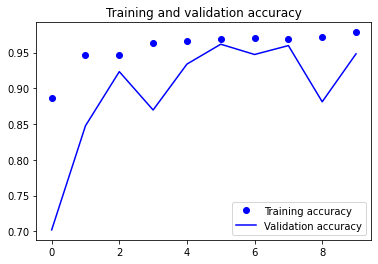

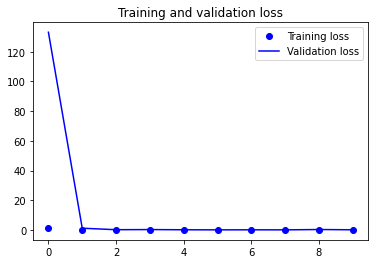

In [54]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [55]:
test_eval = full_model.evaluate(X_test, test_Y_one_hot, verbose=0)

In [56]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.3069112300872803
Test accuracy: 0.6891025900840759


In [57]:
predicted_classes = full_model.predict(X_test)

20/20 [==============================] - 1s 52ms/step


In [58]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [59]:
predicted_classes.shape, y_test.shape

((624,), (624,))

Found 430 correct labels


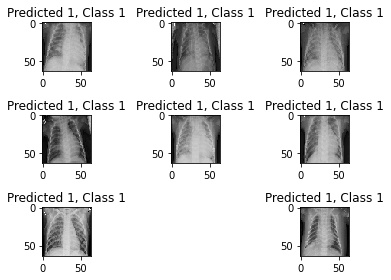

In [61]:
correct = np.where(predicted_classes==y_test)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct], interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

Found 194 incorrect labels


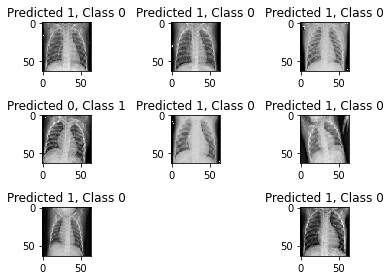

In [63]:
incorrect = np.where(predicted_classes!=y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [64]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.98      0.18      0.30       234
     Class 1       0.67      1.00      0.80       390

    accuracy                           0.69       624
   macro avg       0.82      0.59      0.55       624
weighted avg       0.78      0.69      0.61       624

